In [169]:
import pandas as pd
import json
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
%matplotlib inline

In [170]:
with open('artists.json', 'r') as f:
    artists = json.loads(f.read())

In [174]:
# read data into a list of dataframes then combine
dfs = []
for artist_name in artists.keys(): 
    genre = artists[artist_name]['info'][1]
    for album in artists[artist_name]['albums']: # a list of dictionaries
        album_name = list(album.keys())[0]
        df = pd.DataFrame.from_dict(album[album_name]).T
        df.columns = ['track_num', 'track_title', 'track_length', 'danceability', 'energy',
                      'tempo', 'speechiness', 'valence']
        df['artist'] = artist_name
        df['genre'] = genre
        dfs.append(df)

In [175]:
artist_df = pd.concat(dfs)
artist_df = artist_df.reset_index()

In [176]:
artist_df.head()

,index,track_num,track_title,track_length,danceability,energy,tempo,speechiness,valence,artist,genre
0,0996yf3TIgoHXnLehJhsPe,4,Best One - Remix,192294,0.404,0.823,74.356,0.0719,0.418,Anderson .Paak,deep indie r&b
1,0dwqEpmuc6QAMQtGhFC2us,6,Lyk Dis - Remix,133221,0.415,0.638,87.412,0.0551,0.755,Anderson .Paak,deep indie r&b
2,2JdbuanGl8mxzi8UEnkY7D,2,Livvin - Remix,103196,0.424,0.367,76.235,0.0638,0.138,Anderson .Paak,deep indie r&b
3,2sFuDKUkYPxh72X7moNJME,11,Suede - Uptwnmixx,137021,0.446,0.797,149.706,0.199,0.483,Anderson .Paak,deep indie r&b
4,2tJyUdxdjjAh5Y19e6DvzQ,8,H.A.N. - Remix,158250,0.334,0.615,98.135,0.208,0.62,Anderson .Paak,deep indie r&b


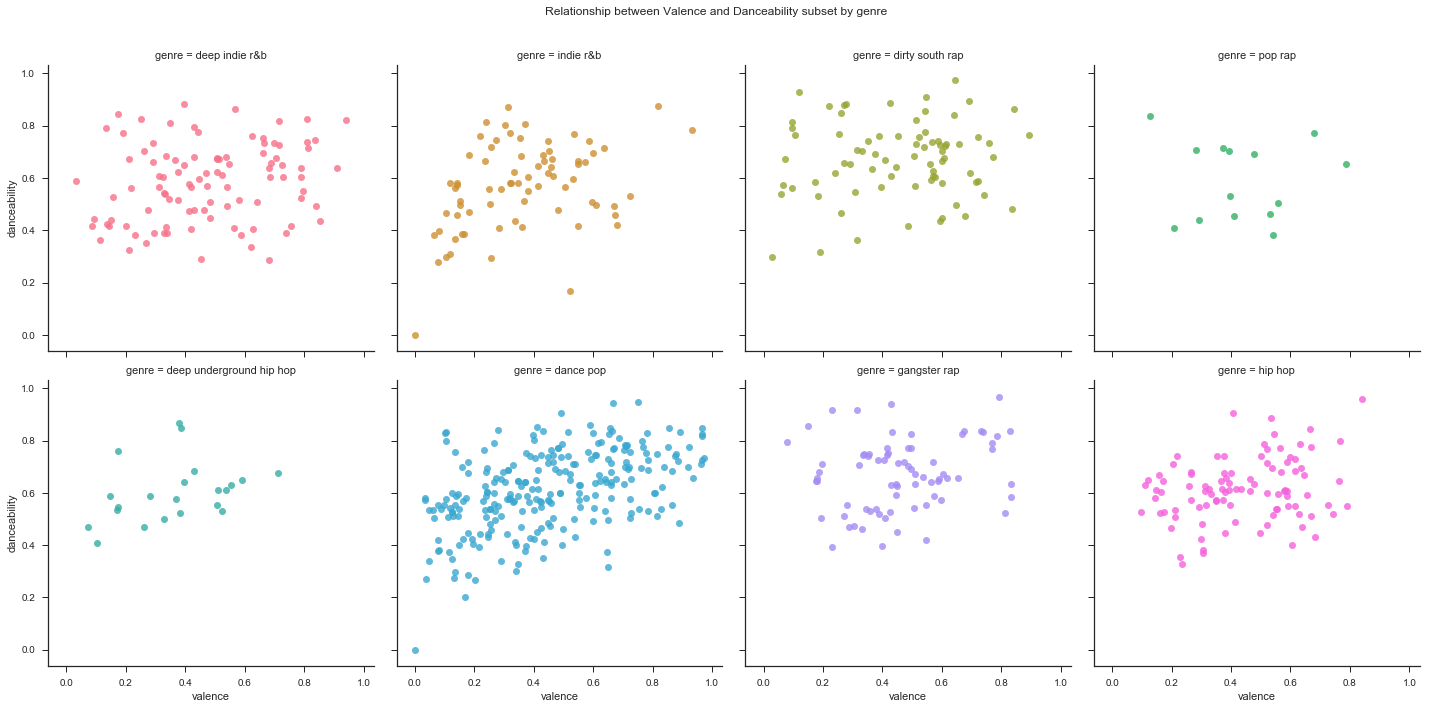

In [193]:
### Plot 1
plt_1 = sns.lmplot(x="valence", y="danceability", fit_reg=False, col='genre', col_wrap=4, hue='genre', data=artist_df);
plt.subplots_adjust(top=0.9)
plt_1.fig.suptitle("Relationship between Valence and Danceability subset by genre")
plt_1.savefig("plot_1.png")


# looking at lyrics

In [85]:
with open('songs.json', 'r') as f:
    songs = json.loads(f.read())

In [145]:
tagged_data = []
song_li = []
for artist in songs.keys():
    for song_id in songs[artist]:
        lyrics = songs[artist][song_id][0]
        tagged_data.append(TaggedDocument(words=word_tokenize(lyrics.lower()), tags=[song_id]))
        df = pd.DataFrame([artist, song_id, lyrics]).T
        df.columns = ['artist', 'song_id', 'lyrics']
        song_li.append(df)


In [146]:
song_df = pd.concat(song_li)

In [101]:
max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1,
                epochs=max_epochs)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49


In [125]:
doc_mat = []
for i in range(len(model.docvecs)):
    doc_mat.append(model.docvecs[i])
doc_mat = np.array(doc_mat)

In [136]:
tsne_model = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_rslt = tsne_model.fit_transform(doc_mat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 624 samples in 0.001s...
[t-SNE] Computed neighbors for 624 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 624 / 624
[t-SNE] Mean sigma: 5.525940
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.330070
[t-SNE] Error after 300 iterations: 1.533053


In [149]:
song_df.head() # in same order as tagged data aka in same order as TSNE

,artist,song_id,lyrics
0,Anderson .Paak,4gszZ10tJQXZiI9SxkO4zM,Jokers and Cinderellas at the ball of confusio...
0,Anderson .Paak,4ecpW3vI1P42ATil2sZCus,Dont do it no favours Night walker youre sham...
0,Anderson .Paak,6EddQZZdY4yK6oFtFIIGBp,Yes lord yeah Tried to tell niggas in 2012 n...
0,Anderson .Paak,44rP6oQL3TpqECCK3OOlg1,If you wonder how I do In the right place Wit...
0,Anderson .Paak,5wWbp6br0ziiy6OZ9iPVz6,A bird with the word came to me The sweetness...


In [151]:
song_df['tsne_x'] = tsne_rslt[:, 0]
song_df['tsne_y'] = tsne_rslt[:, 1]

In [160]:
tsne_df = song_df.merge(artist_df, left_on='song_id', right_on='index')

In [164]:
col_map = {"deep indie r&b": 'r&b', 'indie r&b': 'r&b',
           'dirty south rap': 'rap', 'deep underground hip hop': 'rap', 'gangster rap': 'rap', 'hip hop': 'rap',
           'dance pop': 'hip hop pop', 'pop rap': 'hip hop pop'}

In [165]:
tsne_df['broad_genre'] = tsne_df.genre.map(col_map)

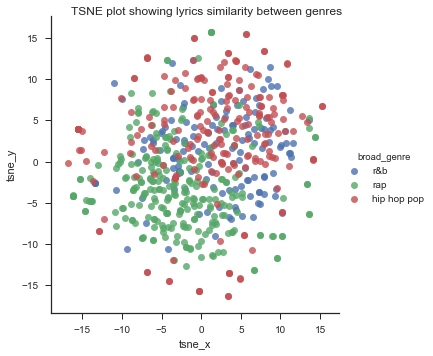

In [194]:
plt_2 = sns.lmplot(x="tsne_x", y="tsne_y", fit_reg=False, hue='broad_genre', data=tsne_df);
plt_2.fig.suptitle("TSNE plot showing lyrics similarity between genres");
plt_2.savefig('plot_2.png')